
# Preparación del problema (Consumo energético → variable para PINN) y elección de la EDO física

En este cuaderno estamos trabajando con datos reales de consumo energético medido por hora para el circuito **`C9_lb_quimica`**. El objetivo final es entrenar una **PINN (Physics-Informed Neural Network)**, pero antes debemos **entender qué representa el dato**, cómo transformarlo a una variable modelable y qué **EDO (ecuación diferencial ordinaria)** tiene sentido como “física” del modelo.

---

## 1) ¿Qué contiene el DataFrame?

El archivo tiene columnas como:

- `fecha` y `tiempo`: definen el instante de medición.
- `C9_lb_quimica`: **consumo energético total en esa hora**, en unidades de **kWh**.
- (otras columnas como `aire_lb_quimica`, etc.)

Como los datos vienen por horas, primero construimos una columna `datetime` y ordenamos el DataFrame cronológicamente.

---

## 2) ¿Por qué NO es corriente directamente?

El valor `C9_lb_quimica(t)` no es corriente instantánea $i(t)$, sino energía acumulada en una hora:

$$E_h \;[\text{kWh}] \approx \int_{t}^{t+1h} P(\tau)\,d\tau$$

Si queremos usar una EDO “tipo circuito” y hablar en términos de corriente, necesitamos convertir ese consumo horario a una magnitud equivalente. Una aproximación estándar es usar potencia promedio por hora:

- Si el consumo es $E_h$ kWh en una hora, entonces la potencia promedio de esa hora es:

$$P_h \;[\text{kW}] = E_h \;[\text{kWh}] / 1\text{h} = E_h \;[\text{kW}]$$

En watts:

$$P_h \;[\text{W}] = 1000\,E_h$$

Y si asumimos una tensión RMS aproximadamente constante (por ejemplo $V_{\text{rms}}=120$ V) y factor de potencia $\text{pf}\approx 1$ (aproximación inicial), estimamos una corriente RMS promedio por hora:

$$I_h \approx \frac{P_h}{V_{\text{rms}}\cdot \text{pf}} = \frac{1000\,E_h}{V_{\text{rms}}\cdot \text{pf}}$$

> **Importante:** Esto NO es la corriente instantánea a 60 Hz. Es una **corriente promedio equivalente por hora**, coherente con el tipo de dato medido.

---

## 3) ¿Por qué NO usar directamente un RLC?

La EDO de un RLC serie en términos de corriente tiene forma (al derivar KVL):

$$L\,i''(t) + R\,i'(t) + \frac{1}{C}i(t) = \frac{d v_s(t)}{dt}$$

Pero nuestros datos (horarios o diarios) muestran:
- muchos ceros,
- picos abruptos,
- activaciones por bloques,
- y **no muestran oscilaciones** típicas de un RLC subamortiguado.

Entonces, usar RLC “literal” forzaría una física que no aparece en la señal agregada.

---

## 4) Modelo más aceptable: RC (primer orden) como dinámica equivalente

Como el consumo agregado se comporta como “sube cuando hay actividad y baja cuando se apaga”, un modelo **de primer orden** (tipo RC o RL) es más coherente:

$$\tau\,i'(t) + i(t) = K\,u(t)$$

donde:
- $i(t)$ representa el consumo equivalente (por ejemplo corriente RMS promedio por hora o consumo diario),
- $\tau$ es una **constante de tiempo** (inercia del sistema),
- $u(t)$ representa una excitación externa (actividad / uso del laboratorio),
- $K$ es una ganancia.

Este modelo produce respuestas suaves: cuando $u(t)$ sube, $i(t)$ crece exponencialmente; cuando $u(t)$ baja, $i(t)$ decae exponencialmente. Eso se parece a lo observado en tus datos agregados.

---

## 5) Visualización del comportamiento de la EDO RC (entrada por tramos)

Para entender la dinámica, simulamos la EDO con una entrada por tramos (encendido/apagado):

$$i'(t) = \frac{K\,u(t) - i(t)}{\tau}$$

y se grafica $i(t)$ comparado con $K\,u(t)$ (referencia). Esta simulación sirve para ver **cómo se comportaría el modelo físico** antes de entrenar la PINN.





# Cargar y limpiar los datos del Excel

In [1]:
import pandas as pd

# Leer archivo Excel
df = pd.read_excel("Bloque30_Laboratorios.xlsx")

# Mostrar información básica
print("Filas y columnas:", df.shape)
print("\nPrimeras 5 filas:")
print(df.head())
print("\nColumnas disponibles:")
print(df.columns.tolist())

Filas y columnas: (6662, 5)

Primeras 5 filas:
       fecha    tiempo  C9_lb_quimica  aire_lb_quimica  Unnamed: 4
0 2024-09-26  10:00:00           0.00              NaN         0.0
1 2024-09-26  11:00:00           0.00              NaN         1.0
2 2024-09-26  12:00:00           0.00              NaN         NaN
3 2024-09-26  13:00:00           0.00              NaN         NaN
4 2024-09-26  14:00:00           2.18              NaN         NaN

Columnas disponibles:
['fecha', 'tiempo', 'C9_lb_quimica', 'aire_lb_quimica', 'Unnamed: 4']


In [2]:
#Crear columna datetime
df["datetime"] = pd.to_datetime(df["fecha"].astype(str) + " " + df["tiempo"].astype(str))

# Ordenar por tiempo
df = df.sort_values("datetime").reset_index(drop=True)

# Eliminar columna Unnamed: 4
df = df.drop(columns=["Unnamed: 4"])

# Eliminar filas con datos vacios, con subset se eliminan bajo esas columnas espesificas
df = df.dropna(subset=["C9_lb_quimica", "aire_lb_quimica"])

print(df[["datetime"]].head())
print("")

print(df.isna().sum())

               datetime
110 2024-10-01 00:00:00
111 2024-10-01 01:00:00
112 2024-10-01 02:00:00
113 2024-10-01 03:00:00
114 2024-10-01 04:00:00

fecha              0
tiempo             0
C9_lb_quimica      0
aire_lb_quimica    0
datetime           0
dtype: int64


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Elegir señal objetivo
df2 = df[["datetime", "C9_lb_quimica"]].copy()

# 2) Quitar NaN y ordenar
# Elimina cualquier fila que tenga valores faltantes en estas dos columnas.
df2 = df2.dropna().sort_values("datetime").reset_index(drop=True)

df2

,datetime,C9_lb_quimica
0,2024-10-01 00:00:00,0.07
1,2024-10-01 01:00:00,0.07
2,2024-10-01 02:00:00,0.07
3,2024-10-01 03:00:00,0.07
4,2024-10-01 04:00:00,0.07
...,...,...
6547,2025-06-30 19:00:00,0.00
6548,2025-06-30 20:00:00,0.00
6549,2025-06-30 21:00:00,0.00
6550,2025-06-30 22:00:00,0.00


### Serie Original

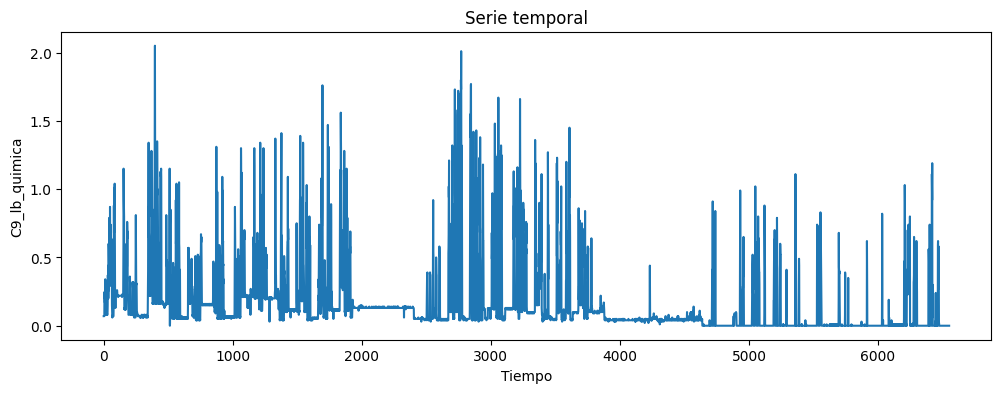

In [4]:
plt.figure(figsize=(12,4))
plt.plot(df2.index, df2["C9_lb_quimica"])
plt.xlabel("Tiempo")
plt.ylabel("C9_lb_quimica")
plt.title("Serie temporal")
plt.show()

### Histograma Serie Original

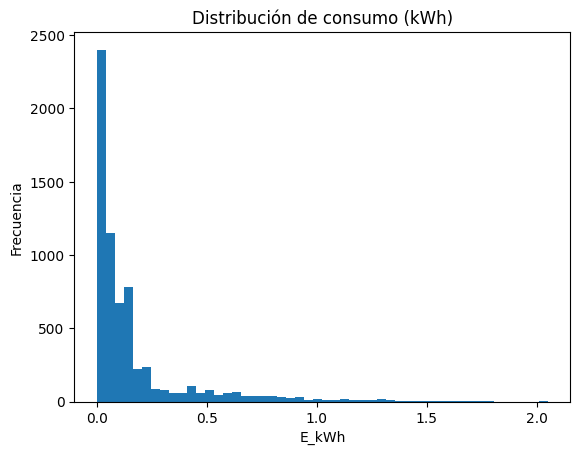

In [5]:
# Histograma para ver distribución
# La mayoría de las horas tienen consumo bajo
plt.figure()
plt.hist(df2["C9_lb_quimica"], bins=50)
plt.xlabel("E_kWh")
plt.ylabel("Frecuencia")
plt.title("Distribución de consumo (kWh)")
plt.show()

# Pasar de consumo (kWh por hora) a una “corriente aproximada”

In [6]:
Vrms = 120.0    # Voltaje RMS típico monofásico en Colombia.
pf = 1.0        # factor de potencia asumido ideal (esto es simplificación).

# df2 ya está ordenado y sin NaN
t_h = (df2["datetime"] - df2["datetime"].min()).dt.total_seconds().values / 3600.0    # 1,2,3,4

E_kWh = df2["C9_lb_quimica"].values.astype(float)   # kWh por hora
P_W   = 1000.0 * E_kWh                              # W promedio en esa hora
I_A   = P_W / (Vrms * pf)                           # A RMS promedio (aprox) Corriente RMS promedio durante esa hora.

print("t_h:", t_h.min(), "->", t_h.max())
print("I_A:", I_A.min(), "->", I_A.max())


t_h: 0.0 -> 6551.0
I_A: 0.0 -> 17.083333333333332


# Simulación Entradas Protoripo al RLC

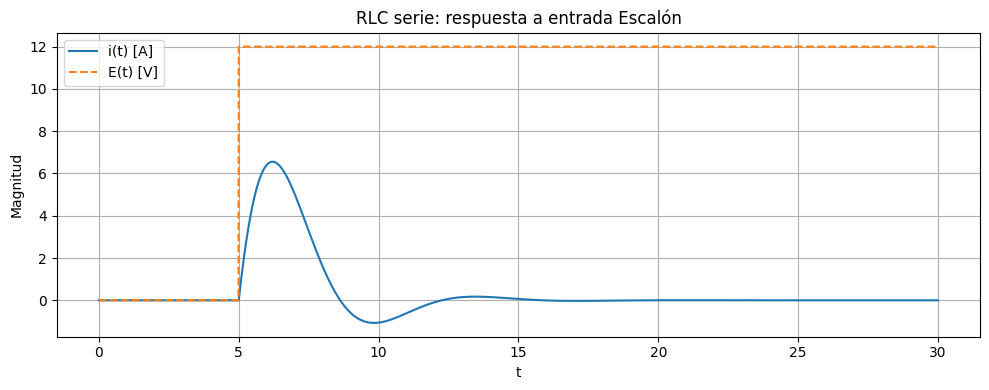

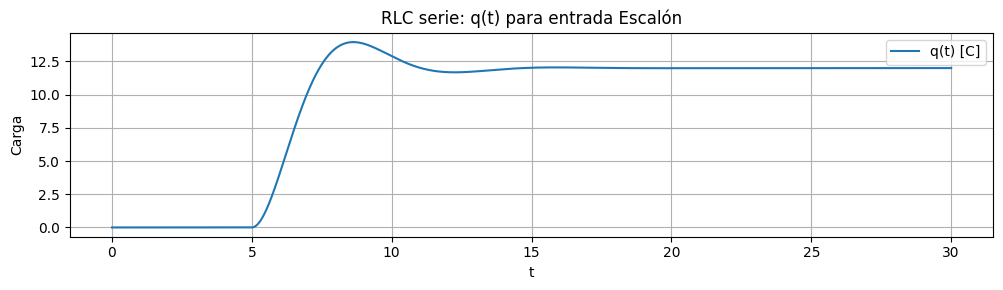

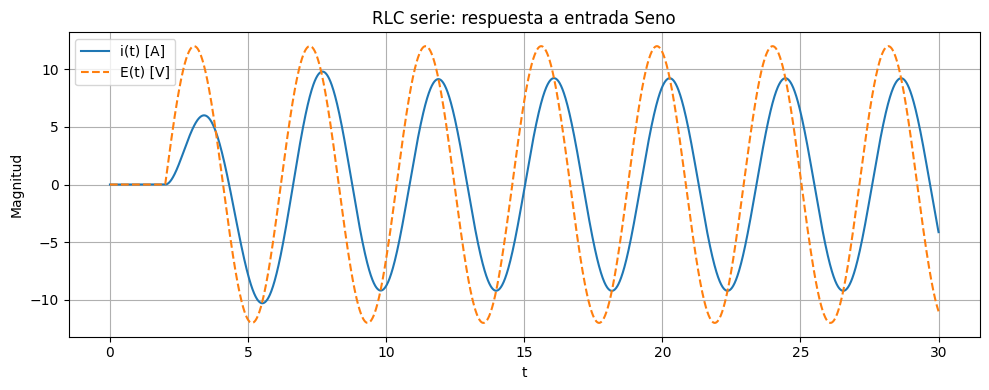

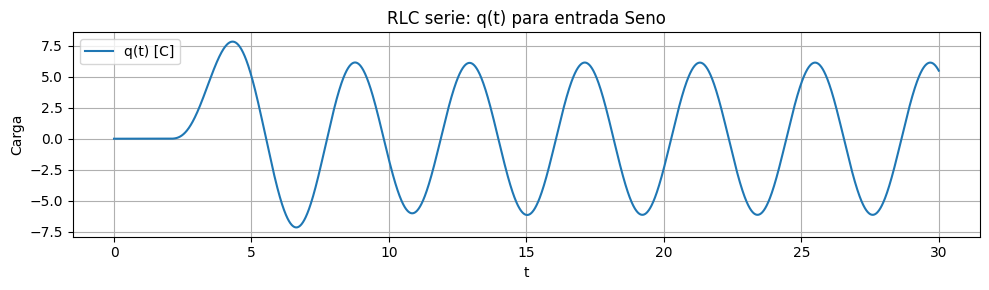

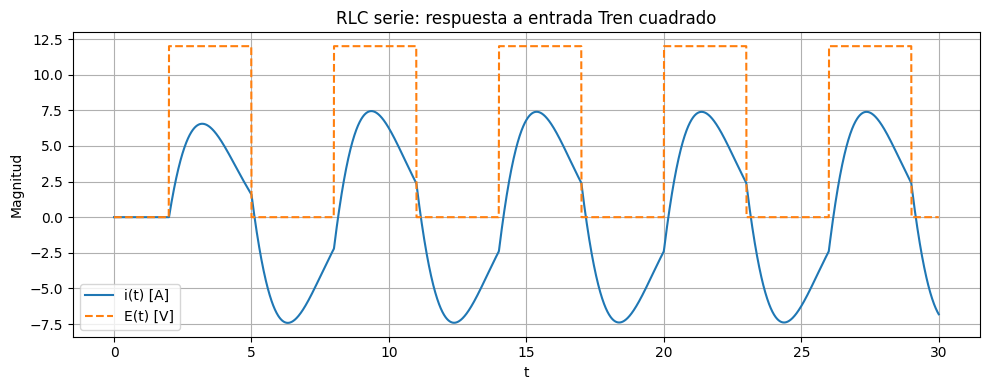

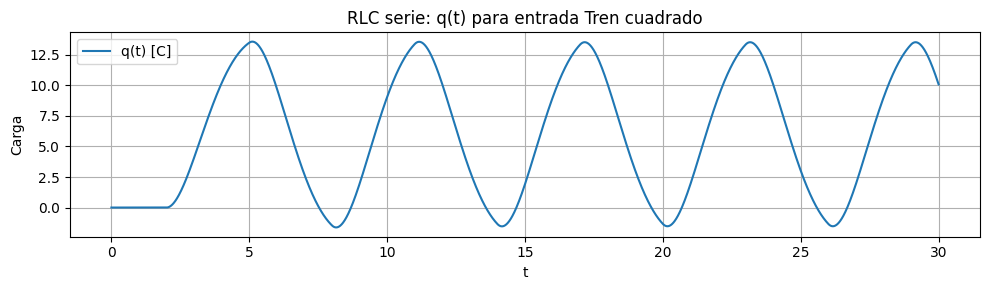

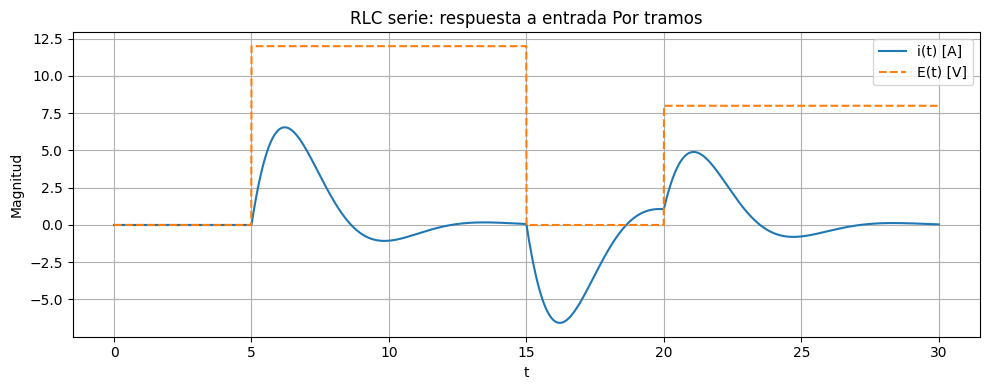

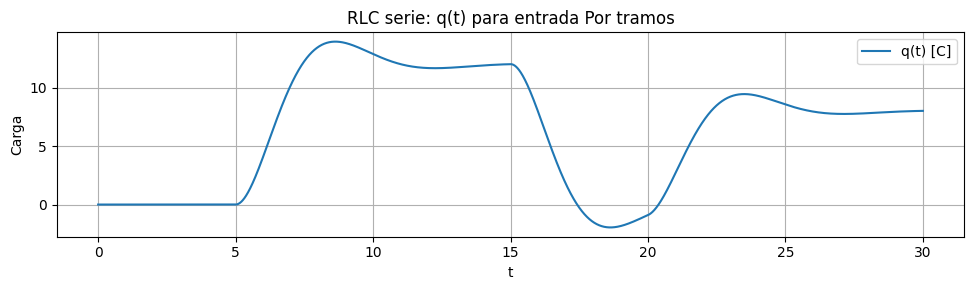


Interpretación rápida:
- Si ves oscilaciones amortiguadas en i(t): el RLC está en régimen subamortiguado (2º orden con oscilación).
- Si no oscila y solo sube/baja suave: está sobreamortiguado o críticamente amortiguado (más parecido a un RC/RL).
- Cambia R, L, C para ver transitorios más rápidos/lentos:
  * ↑R -> más amortiguamiento (menos oscilación)
  * ↑L o ↑C -> respuesta más lenta (frecuencia natural menor)

  Lo que imprime al final te guía:
  Si ves oscilaciones amortiguadas → subamortiguado.
  Si no oscila → sobreamortiguado o crítico.
  Cambiar parámetros:
  ↑R amortigua más
  ↑L o ↑C hace más lenta la dinámica



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================================================
# RESPUESTA DE UN RLC EN SERIE A DIFERENTES ENTRADAS E(t)
# Modelo (KVL):
#   L di/dt + R i + (1/C) q = E(t)
#   dq/dt = i
#
# Estados: X = [i, q]
#   di/dt = (E(t) - R*i - q/C)/L
#   dq/dt = i
# ============================================================

# -----------------------------
# 1) Parámetros del RLC (ajusta)
# -----------------------------
#R = 5.0       # Ohm
#L = 0.5       # Henry
#C = 0.2       # Farad

R = 1       # Ohm
L = 1       # Henry
C = 1       # farad

# Condiciones iniciales
i0 = 0.0                    # circuito inicia sin corriente.
q0 = 0.0                    # capacitor descargado.

# Tiempo de simulación
t0, tf = 0.0, 30.0
t_eval = np.linspace(t0, tf, 3000) # 3000 puntos para una curva suave

# -----------------------------
# 2) Definir varias entradas E(t)
# -----------------------------
def E_step(t, E0=10.0, t_on=5.0):
    """Escalón: 0 antes de t_on, E0 después."""
    return E0 if t >= t_on else 0.0

def E_sine(t, E0=10.0, w=2.0, t_on=0.0):
    """Seno: 0 antes de t_on, seno después."""
    return 0.0 if t < t_on else E0*np.sin(w*(t - t_on))

def E_square_train(t, E0=10.0, period=6.0, duty=0.5, t_on=0.0):
    """Tren cuadrado: on/off periódico."""
    if t < t_on:
        return 0.0
    tt = (t - t_on) % period
    return E0 if tt < duty*period else 0.0

def E_piecewise(t):
    """Por tramos tipo ON/OFF (parecido a lo que venías usando)."""
    if 5 <= t < 15:
        return 12.0
    if 20 <= t <= 30:
        return 8.0
    return 0.0

# Lista de casos a simular. Esto te permite recorrerlos en un for sin repetir código.
cases = [
    ("Escalón",       lambda t: E_step(t, E0=12.0, t_on=5.0)),
    ("Seno",          lambda t: E_sine(t, E0=12.0, w=1.5, t_on=2.0)),
    ("Tren cuadrado", lambda t: E_square_train(t, E0=12.0, period=6.0, duty=0.5, t_on=2.0)),
    ("Por tramos",    E_piecewise),
]

# -----------------------------
# 3) Dinámica del RLC (EDO), Dinámica del RLC en forma de estado
# -----------------------------
def rlc_ode(t, X, E_fun):
    i, q = X
    E = E_fun(t)
    di_dt = (E - R*i - (q/C)) / L
    dq_dt = i
    return [di_dt, dq_dt]

# -----------------------------
# 4) Simular y graficar (una figura por entrada, sin subplots)
#     Se resuelve X(t) para ese E(t)
# -----------------------------
for title, E_fun in cases:
    sol = solve_ivp(
        fun=lambda t, X: rlc_ode(t, X, E_fun),
        t_span=(t0, tf),
        y0=[i0, q0],
        t_eval=t_eval,
        method="RK45",
        rtol=1e-7,        #rtol y atol controlan la precisión.
        atol=1e-9
    )
    i_t = sol.y[0]        # rtol y atol controlan la precisión.
    q_t = sol.y[1]
    E_t = np.array([E_fun(tt) for tt in t_eval])

    # Figura 1: Corriente i(t) y entrada E(t) (misma figura, dos curvas)
    plt.figure(figsize=(10, 4))
    plt.plot(t_eval, i_t, label="i(t) [A]")
    plt.plot(t_eval, E_t, "--", label="E(t) [V]")
    plt.xlabel("t")
    plt.ylabel("Magnitud")
    plt.title(f"RLC serie: respuesta a entrada {title}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figura 2: Carga q(t) (útil para ver el estado del capacitor)
    plt.figure(figsize=(10, 3))
    plt.plot(t_eval, q_t, label="q(t) [C]")
    plt.xlabel("t")
    plt.ylabel("Carga")
    plt.title(f"RLC serie: q(t) para entrada {title}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# 5) Nota para interpretar rápido
# -----------------------------
print("""
Interpretación rápida:
- Si ves oscilaciones amortiguadas en i(t): el RLC está en régimen subamortiguado (2º orden con oscilación).
- Si no oscila y solo sube/baja suave: está sobreamortiguado o críticamente amortiguado (más parecido a un RC/RL).
- Cambia R, L, C para ver transitorios más rápidos/lentos:
  * ↑R -> más amortiguamiento (menos oscilación)
  * ↑L o ↑C -> respuesta más lenta (frecuencia natural menor)

  Lo que imprime al final te guía:
  Si ves oscilaciones amortiguadas → subamortiguado.
  Si no oscila → sobreamortiguado o crítico.
  Cambiar parámetros:
  ↑R amortigua más
  ↑L o ↑C hace más lenta la dinámica
""")


# Simulación Entradas Protoripo al RC

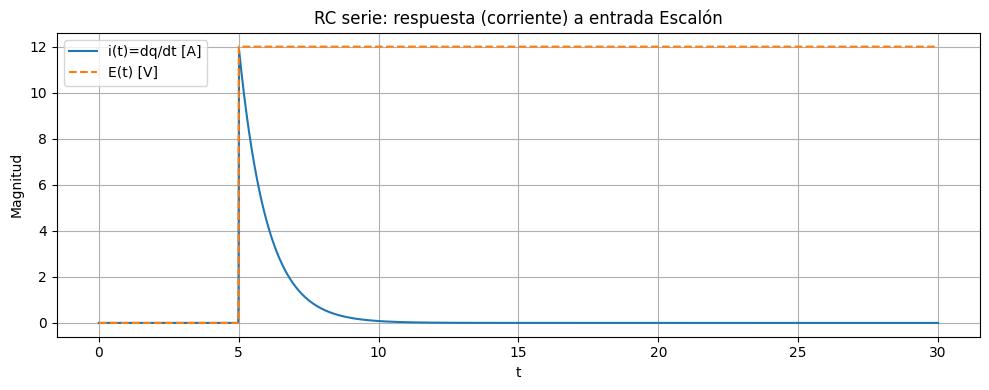

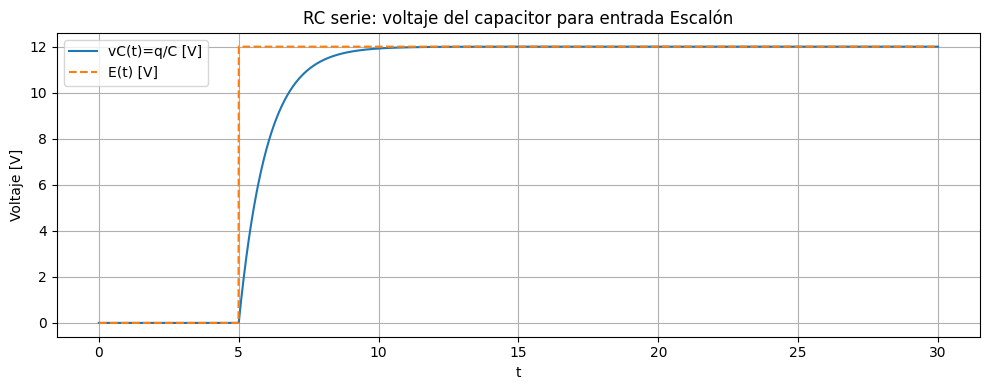

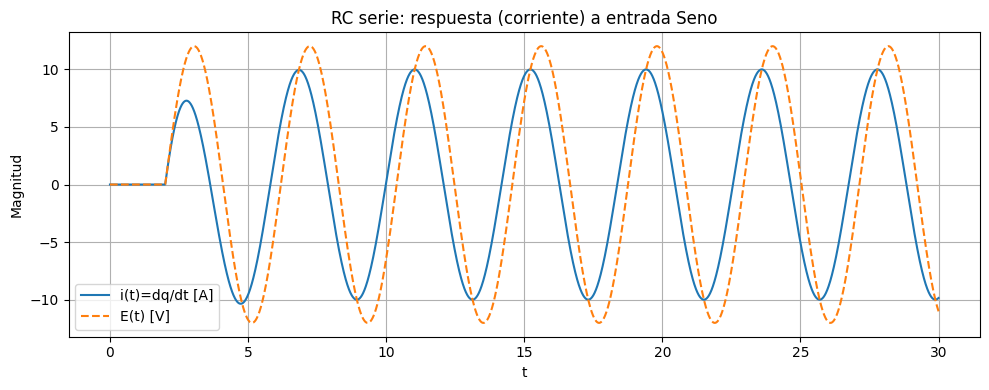

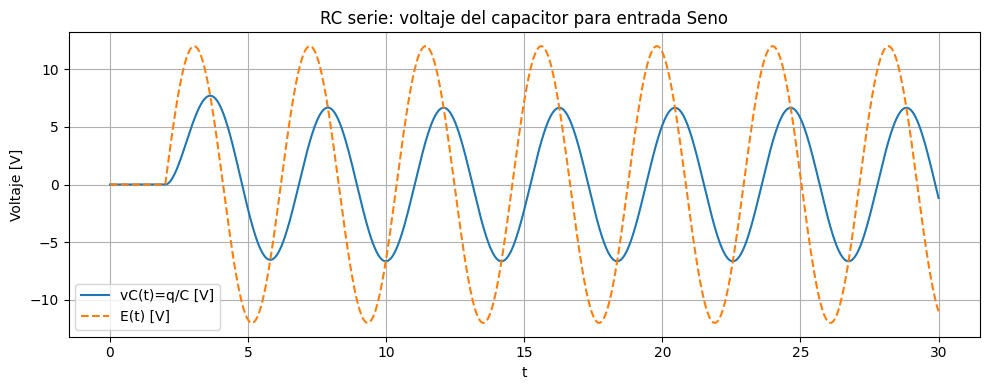

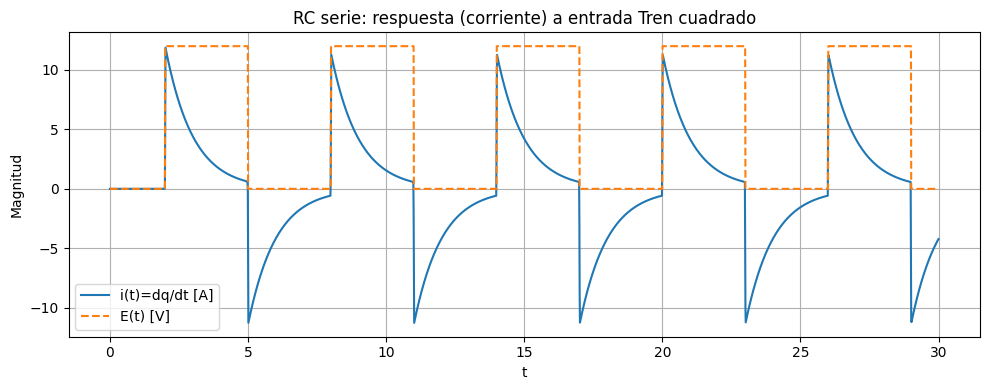

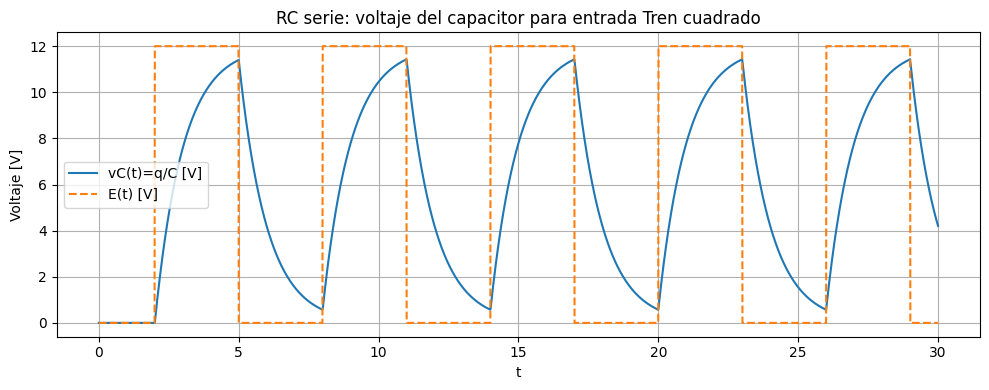

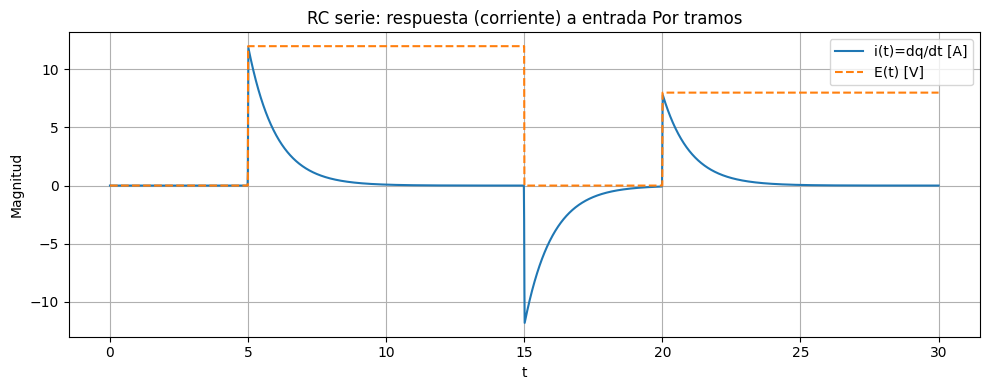

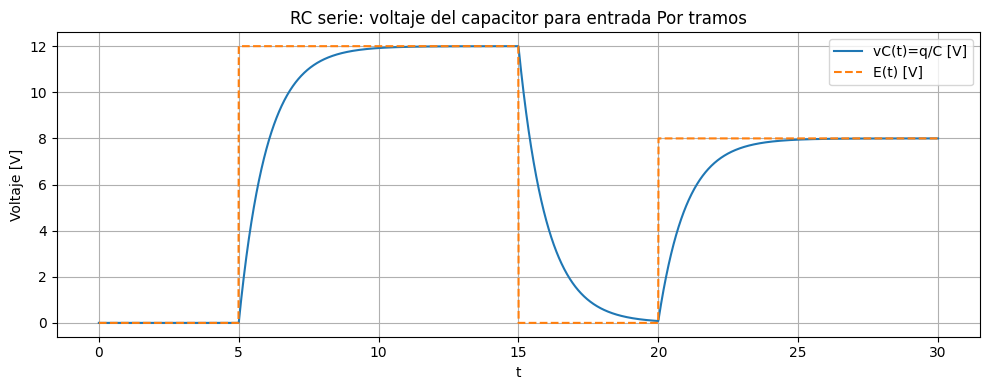


Interpretación rápida (RC):
- No hay oscilaciones: el RC es 1er orden (respuesta exponencial).
- La constante de tiempo es tau = R*C:
  * ↑R o ↑C  -> respuesta más lenta (tau mayor)
  * ↓R o ↓C  -> respuesta más rápida (tau menor)
- En un escalón de voltaje, vC(t) sube exponencialmente hacia E0,
  y la corriente i(t) empieza alta y decae exponencialmente a 0.



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================================================
# RESPUESTA DE UN RC EN SERIE A DIFERENTES ENTRADAS E(t)
# Modelo (KVL) en términos de la CARGA q(t):
#   R * dq/dt + (1/C) * q = E(t)
#
# Donde:
#   i(t) = dq/dt
#   vC(t) = q/C
#
# Estado: q(t)
#   dq/dt = (E(t) - q/C) / R
# ============================================================

# -----------------------------
# 1) Parámetros del RC (ajusta)
# -----------------------------
R = 1.0   # Ohm
C = 1.0   # Farad

# Condición inicial
q0 = 0.0  # capacitor descargado (Coulomb)

# Tiempo de simulación
t0, tf = 0.0, 30.0
t_eval = np.linspace(t0, tf, 3000)

# -----------------------------
# 2) Definir varias entradas E(t)
# -----------------------------
def E_step(t, E0=10.0, t_on=5.0):
    """Escalón: 0 antes de t_on, E0 después."""
    return E0 if t >= t_on else 0.0

def E_sine(t, E0=10.0, w=2.0, t_on=0.0):
    """Seno: 0 antes de t_on, seno después."""
    return 0.0 if t < t_on else E0 * np.sin(w * (t - t_on))

def E_square_train(t, E0=10.0, period=6.0, duty=0.5, t_on=0.0):
    """Tren cuadrado: on/off periódico."""
    if t < t_on:
        return 0.0
    tt = (t - t_on) % period
    return E0 if tt < duty * period else 0.0

def E_piecewise(t):
    """Por tramos tipo ON/OFF (parecido a lo que venías usando)."""
    if 5 <= t < 15:
        return 12.0
    if 20 <= t <= 30:
        return 8.0
    return 0.0

cases = [
    ("Escalón",       lambda t: E_step(t, E0=12.0, t_on=5.0)),
    ("Seno",          lambda t: E_sine(t, E0=12.0, w=1.5, t_on=2.0)),
    ("Tren cuadrado", lambda t: E_square_train(t, E0=12.0, period=6.0, duty=0.5, t_on=2.0)),
    ("Por tramos",    E_piecewise),
]

# -----------------------------
# 3) Dinámica del RC (EDO)
#    dq/dt = (E(t) - q/C)/R
# -----------------------------
def rc_ode(t, q, E_fun):
    E = E_fun(t)
    dq_dt = (E - (q / C)) / R
    return dq_dt

# -----------------------------
# 4) Simular y graficar (una figura por entrada, sin subplots)
# -----------------------------
for title, E_fun in cases:
    sol = solve_ivp(
        fun=lambda t, q: rc_ode(t, q, E_fun),
        t_span=(t0, tf),
        y0=[q0],
        t_eval=t_eval,
        method="RK45",
        rtol=1e-7,
        atol=1e-9
    )

    q_t = sol.y[0]                          # carga [C]
    i_t = np.gradient(q_t, t_eval)          # corriente aproximada i=dq/dt [A]
    vC_t = q_t / C                          # voltaje capacitor [V]
    E_t = np.array([E_fun(tt) for tt in t_eval])

    # Figura 1: Corriente i(t) y entrada E(t)
    plt.figure(figsize=(10, 4))
    plt.plot(t_eval, i_t, label="i(t)=dq/dt [A]")
    plt.plot(t_eval, E_t, "--", label="E(t) [V]")
    plt.xlabel("t")
    plt.ylabel("Magnitud")
    plt.title(f"RC serie: respuesta (corriente) a entrada {title}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figura 2: Voltaje del capacitor vC(t) y entrada E(t)
    plt.figure(figsize=(10, 4))
    plt.plot(t_eval, vC_t, label="vC(t)=q/C [V]")
    plt.plot(t_eval, E_t, "--", label="E(t) [V]")
    plt.xlabel("t")
    plt.ylabel("Voltaje [V]")
    plt.title(f"RC serie: voltaje del capacitor para entrada {title}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# 5) Nota para interpretar rápido
# -----------------------------
print("""
Interpretación rápida (RC):
- No hay oscilaciones: el RC es 1er orden (respuesta exponencial).
- La constante de tiempo es tau = R*C:
  * ↑R o ↑C  -> respuesta más lenta (tau mayor)
  * ↓R o ↓C  -> respuesta más rápida (tau menor)
- En un escalón de voltaje, vC(t) sube exponencialmente hacia E0,
  y la corriente i(t) empieza alta y decae exponencialmente a 0.
""")


In [9]:
!pip -q install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.7 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd

# ==========================================
# PUENTE INTERMEDIO (mínimo + suavizado ligero EMA)
# - Requiere df2 con columnas: ["datetime","C9_lb_quimica"]
# - Produce df_h con: ["datetime","I_A","I_smooth","t_h","t_n","u"]
# ==========================================

Vrms = 120.0
pf   = 1.0
COL_ENERGIA = "C9_lb_quimica"

# 1) Limpieza básica
df2 = df2.copy()
df2["datetime"] = pd.to_datetime(df2["datetime"], errors="coerce")
df2[COL_ENERGIA] = pd.to_numeric(df2[COL_ENERGIA], errors="coerce")
df2 = df2.dropna(subset=["datetime", COL_ENERGIA]).sort_values("datetime")

# 2) (Recomendado) malla horaria uniforme + interpolación
df_h = (
    df2.set_index("datetime")
       .resample("1h").mean()               # consolida duplicados por hora
       .interpolate(method="time")          # rellena horas faltantes
       .dropna(subset=[COL_ENERGIA])
       .reset_index()
)

# 3) kWh/h -> I_A (A RMS aprox)
E_kWh = df_h[COL_ENERGIA].values.astype(float)
P_W   = 1000.0 * E_kWh
df_h["I_A"] = P_W / (Vrms * pf)

# 4) Suavizado ligero: SOLO EMA (más simple que mediana+EMA)
#    span_ema controla cuánta "memoria" tiene el filtro (horas).
#    Ajuste típico inicial: 6 a 24.
span_ema = 12
df_h["I_smooth"] = df_h["I_A"].ewm(span=span_ema, adjust=False).mean()

# 5) Tiempo: t_h (horas desde inicio) y t_n (0..1)
t_h = (df_h["datetime"] - df_h["datetime"].min()).dt.total_seconds().values / 3600.0
df_h["t_h"] = t_h
df_h["t_n"] = (t_h - t_h.min()) / (t_h.max() - t_h.min() + 1e-12)

# 6) Entrada u(t) derivada de datos (0..1) desde I_smooth (robusto con percentiles)
I = df_h["I_smooth"].values
p05, p95 = np.percentile(I, 5), np.percentile(I, 95)
u = (I - p05) / (p95 - p05 + 1e-12)
df_h["u"] = np.clip(u, 0.0, 1.0)

print("df_h listo:", df_h.shape)
print("Columnas:", df_h.columns.tolist())
print("Rango:", df_h["datetime"].min(), "->", df_h["datetime"].max())
print("I_A   min/max:", df_h["I_A"].min(), df_h["I_A"].max())
print("u(t)  min/max:", df_h["u"].min(), df_h["u"].max())
print("span_ema usado:", span_ema)


df_h listo: (6552, 7)
Columnas: ['datetime', 'C9_lb_quimica', 'I_A', 'I_smooth', 't_h', 't_n', 'u']
Rango: 2024-10-01 00:00:00 -> 2025-06-30 23:00:00
I_A   min/max: 0.0 17.083333333333332
u(t)  min/max: 0.0 1.0
span_ema usado: 12


# Implementacion PINN con Biblioteca DeepXDE

No backend selected.
Finding available backend...
Found tensorflow
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
'compile' took 0.016377 s

Training model...

Step      Train loss              Test loss               Test metric
0         [8.93e-02, 1.31e+01]    [nan, 1.31e+01]         []  

Best model at step 0:
  train loss: 1.32e+01
  test loss: nan
  test metric: []

'train' took 4.157027 s

Compiling model...
'compile' took 0.005934 s

Training model...

Step      Train loss              Test loss               Test metric
1         [4.38e-02, 1.15e+01]    [nan, 1.15e+01]         []  
1650      [2.63e-03, 3.67e-01]    [nan, 3.67e-01]         []  

Best model at step 1650:
  train loss: 3.70e-01
  test loss: nan
  test metric: []

'train' took 771.118816 s



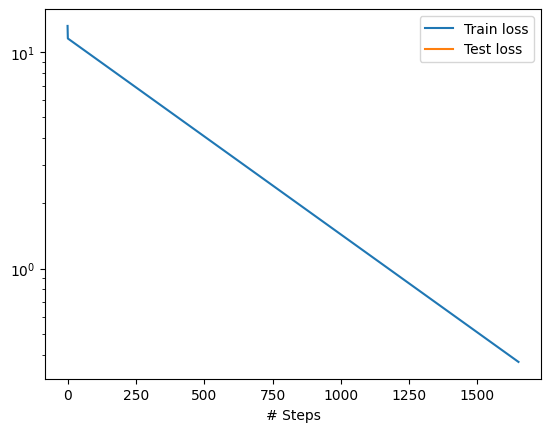

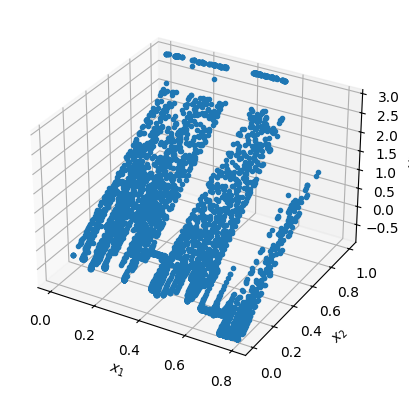


=== Métricas (TEST) ===
MAE  : 0.0316 A
RMSE : 0.2744 A
R2   : 0.8674

=== Parámetros aprendidos ===
K   (A aprox): 5.269128
tau (en unidades de t_n): 23.999775
tau (horas aprox): 157222.526


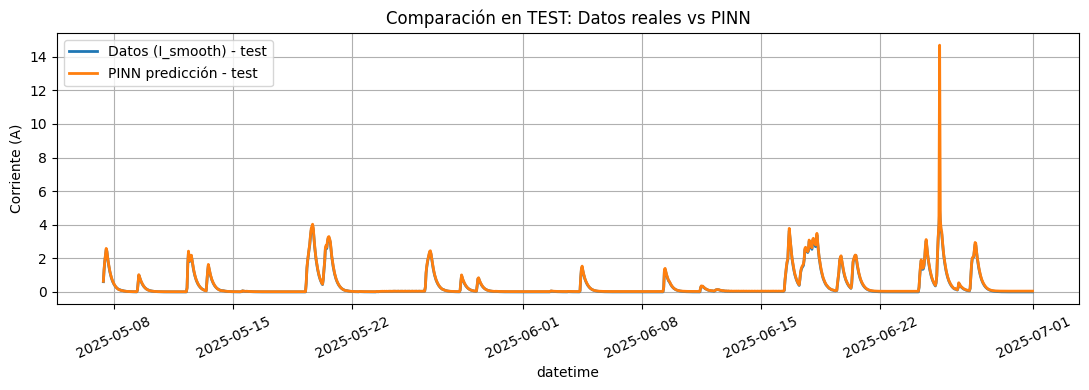

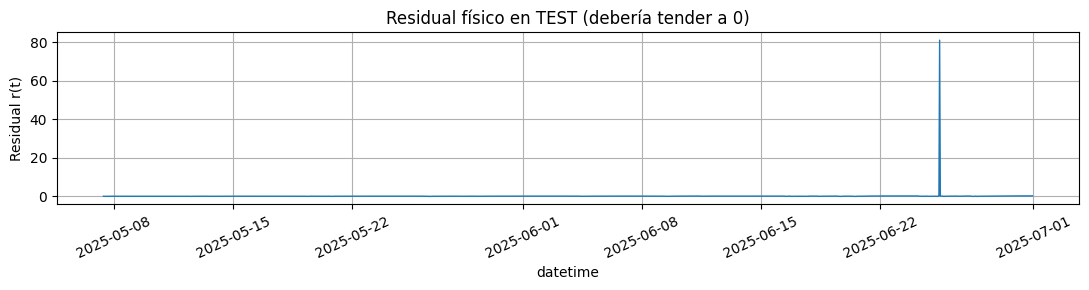

In [11]:
# ============================================================
# PINN con DeepXDE para datos reales (horarios)
# Física tipo RC efectiva:  di/dt = (K*u(t) - i)/tau
#
#
# Requisitos previos:
# - Debes tener ya construido df_h con columnas:
#   ["t_n", "I_smooth", "u"]  (del bloque anterior)
#   * t_n en [0,1] (tiempo normalizado)
#   * I_smooth = señal suavizada (A)
#   * u = entrada derivada de datos en [0,1]
# ============================================================

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Preparar X, y desde df_h
# -----------------------------
# X tendrá 2 entradas: [t, u(t)]
# Esto evita tener que "interpolar u" dentro de la PDE (más simple y estable).
t = df_h["t_n"].values.reshape(-1, 1).astype(np.float32)       # tiempo normalizado [0,1]
u = df_h["u"].values.reshape(-1, 1).astype(np.float32)         # entrada derivada [0,1]
y = df_h["I_smooth"].values.reshape(-1, 1).astype(np.float32)  # observación (A)

X = np.hstack([t, u])  # (N,2)

# Normalizar y (muy recomendable para entrenar redes)
y_mean, y_std = y.mean(), y.std() + 1e-8
y_n = (y - y_mean) / y_std

# -----------------------------
# 2) Split temporal Train/Test
# -----------------------------
# Entrenamos con el 80% inicial y evaluamos en el 20% final
N = len(X)
split = int(0.8 * N)

X_train, y_train = X[:split], y_n[:split]
X_test,  y_test  = X[split:], y_n[split:]

# -----------------------------
# 3) Parámetros entrenables (K y tau)
# -----------------------------
# DeepXDE permite variables entrenables con dde.Variable (backend TF por defecto).
# Para garantizar positividad usamos softplus: softplus(z) > 0.
# (Si te salen warnings del backend, es normal; DeepXDE usa TF/PyTorch según config.)

# Variables entrenables durante el entremaniendo... Identificación de parámetros físicos con PINNs
K_raw   = dde.Variable(0.0)   # se transformará a K_pos = softplus(K_raw)
tau_raw = dde.Variable(2.0)   # se transformará a tau_pos = softplus(tau_raw)

# -----------------------------
# 4) Definir la "PDE" (aquí es ODE residual)
# -----------------------------
# x = [t, u]
# y = i_theta(t,u)
#
# residual:
#   r = di/dt - (K*u - i)/tau
#
# Nota: derivamos SOLO respecto a t (columna 0 de x).
def ode_residual(x, y):
    # Derivada dy/dt (t es la columna 0)
    dy_dt = dde.grad.jacobian(y, x, i=0, j=0)

    # u(t) entra como segunda columna de x
    u_in = x[:, 1:2]

    # Softplus para forzar K>0 y tau>0
    # (dde.backend.tf existe cuando backend es TensorFlow)
    import tensorflow as tf
    K_pos   = tf.nn.softplus(K_raw) + 1e-6 # garantizar que no sean 0
    tau_pos = tf.nn.softplus(tau_raw) + 1e-6

    return dy_dt - (K_pos * u_in - y) / tau_pos

# -----------------------------
# 5) Geometría: PointCloud (usamos los puntos reales como dominio)
# -----------------------------
# Esto significa: el residual físico se evalúa en los puntos (t,u) disponibles. conjuntos de puntos discrtos donde se evalua la fisica
# Mi dominio físico no es un intervalo continuo

geom = dde.geometry.PointCloud(X_train)

# -----------------------------
# 6) Condición "de datos" (PointSetBC)
# -----------------------------
# Obliga a la red a acercarse a y_train en los puntos observados.
bc_data = dde.icbc.PointSetBC(X_train, y_train, component=0)     # Aplica esta condición a la primera (y única) salida

# -----------------------------
# 7) Construir el dataset para DeepXDE
# -----------------------------
# num_domain: cuántos puntos usa para el residual físico por iteración (muestreados del PointCloud).
# anchors: puntos que siempre se incluyen (puedes poner X_train para asegurar cobertura)
data = dde.data.PDE(                                                                #“Así es como se construye el problema físico + datos que voy a entrenar.”
    geom,
    ode_residual,
    [bc_data],
    num_domain=2000,     # residual físico en 2000 del dominio puntos por iteración
    num_boundary=0,      # No tienes frontera espacialx
    anchors=X_train,     # asegura que el residual también vea los puntos reales
    num_test=0           # No se genera un conjunto físico interno para test.
)

# -----------------------------
# 8) Red neuronal
# -----------------------------
# Entrada: 2 (t y u)
# Salida: 1 (i_n)
net = dde.nn.FNN([2, 64, 64, 64, 1], "tanh", "Glorot normal")

model = dde.Model(data, net)

# -----------------------------
# 9) Pesos lambda (entre 0 y 1) para Data y Física
# -----------------------------
# DeepXDE internamente tiene una pérdida por cada "componente":
# - Para nuestro caso: [loss_phys, loss_data]
#
# Aquí fijamos lambdas en [0,1] para interpretación simple:
lambda_phys = 2
lambda_data = 10

# -----------------------------
# 10) Compilar y entrenar (Adam + L-BFGS)
# -----------------------------
model.compile(
    "adam",
    lr=1e-3,
    loss_weights=[lambda_phys, lambda_data],
    external_trainable_variables=[K_raw, tau_raw],
)

losshistory, train_state = model.train(iterations=8000)

# Refinamiento con L-BFGS (mejora ajuste final normalmente)
model.compile(
    "L-BFGS",
    loss_weights=[lambda_phys, lambda_data],
    external_trainable_variables=[K_raw, tau_raw],
)
losshistory, train_state = model.train()

# Guardar/plot de pérdidas (opcional, pero útil)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

# -----------------------------
# 11) Predicción y métricas (en escala original)
# -----------------------------
y_pred_test_n = model.predict(X_test)              # pred en escala normalizada
y_pred_test   = y_pred_test_n * y_std + y_mean     # desnormalizar
y_true_test   = y_test * y_std + y_mean            # desnormalizar

# Métricas
mae = np.mean(np.abs(y_true_test - y_pred_test))
mse = np.mean((y_true_test - y_pred_test) ** 2)
rmse = np.sqrt(mse)

# R2
ss_res = np.sum((y_true_test - y_pred_test) ** 2)
ss_tot = np.sum((y_true_test - np.mean(y_true_test)) ** 2) + 1e-12
r2 = 1 - ss_res / ss_tot

print("\n=== Métricas (TEST) ===")
print(f"MAE  : {mae:.4f} A")
print(f"RMSE : {rmse:.4f} A")
print(f"R2   : {r2:.4f}")

# -----------------------------
# 12) Reportar K y tau aprendidos
# -----------------------------
# Convertimos K_raw y tau_raw a su versión positiva (softplus)
import tensorflow as tf
K_learned   = tf.nn.softplus(K_raw).numpy()
tau_learned = tf.nn.softplus(tau_raw).numpy()

print("\n=== Parámetros aprendidos ===")
print(f"K   (A aprox): {K_learned:.6f}")
print(f"tau (en unidades de t_n): {tau_learned:.6f}")

# Ojo:
# tau está en escala del tiempo NORMALIZADO (t_n).
# Si quieres tau en horas, usa:
#   t_real_horas = (t_max_real - t_min_real)
#   tau_horas ≈ tau_learned * (t_max_real - t_min_real)
# Como aquí t_n va de 0 a 1 en todo el rango, el rango real en horas sería:
t_real_range_h = df_h["t_h"].values.max() - df_h["t_h"].values.min()
tau_horas = tau_learned * t_real_range_h
print(f"tau (horas aprox): {tau_horas:.3f}")

# -----------------------------
# 13) Gráficas: datos vs PINN (test)
# -----------------------------
# Para graficar en tiempo real (datetime) sobre el tramo test:
dt_test = df_h["datetime"].values[split:]
plt.figure(figsize=(11,4))
plt.plot(dt_test, y_true_test, label="Datos (I_smooth) - test", linewidth=2)
plt.plot(dt_test, y_pred_test, label="PINN predicción - test", linewidth=2)
plt.xlabel("datetime")
plt.ylabel("Corriente (A)")
plt.title("Comparación en TEST: Datos reales vs PINN")
plt.xticks(rotation=25)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 14) Residual físico (qué tan bien cumple la EDO)
# -----------------------------
# Evaluamos residual r(t) en test (mientras más cerca de 0, mejor)
res_test = model.predict(X_test, operator=ode_residual)  # residual en escala normalizada
plt.figure(figsize=(11,3))
plt.plot(dt_test, res_test, linewidth=1)
plt.xlabel("datetime")
plt.ylabel("Residual r(t)")
plt.title("Residual físico en TEST (debería tender a 0)")
plt.xticks(rotation=25)
plt.grid(True)
plt.tight_layout()
plt.show()
